In [1]:
# Enable autoreload to automatically reload modules when they are updated
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from typing import Dict, Any, Optional, Union
import joblib
import psutil, shutil
import os
import numpy as np
from sarpyx.processor.core.focus import CoarseRDA
from sarpyx.utils.zarr_utils import ZarrManager, dask_slice_saver, concatenate_slices_efficient

# Only add path if not already added
cwd = Path.cwd()
sarpyx_path = cwd.parent
if str(sarpyx_path) not in __import__('sys').path:
    __import__('sys').path.append(str(sarpyx_path))
    
# Output directory for focused data
output_dir = cwd.parent / 'focused_data' 
tmp_dir = output_dir / 'tmp'

In [ ]:
# ------- Input -------
file_path = "/Data_large/marine/PythonProjects/SAR/sarpyx/decoded_data/s1a-s1-raw-s-hh-20150519t121652-20150519t121725-005990-007b7d_burst_0.zarr"
# ------- Configure the handler for processing -------
productName = Path(file_path).stem
N_SLICES = 5
# ------- Init -------
# STEP1: Data Focusing Preparation
handler = ZarrManager(file_path)
# Starting focusing in steps:
for SLICE_N in range(N_SLICES): 
    raw_data = handler.get_slice_block(slice_idx=SLICE_N, N_blocks=N_SLICES)
    print(f'📊 Sliced raw data shape: {raw_data["echo"].shape} ')

    processor = CoarseRDA(
                raw_data=raw_data,  # type: ignore
                verbose=False,
            )
    print(f'🛠️ Processor initialized with raw data of shape: {raw_data["echo"].shape}')
    processor.data_focus()
    
    raw = processor.raw_data
    rc = processor.range_compressed_data
    rcmc = processor.rcmc_data
    az = processor.azimuth_compressed_data
    metadata = raw_data['metadata'].to_dict()
    ephemeris = raw_data['ephemeris'].to_dict()
    
    # Ensure all data types are as expected
    assert isinstance(metadata, dict), f'Expected metadata to be dict, got {type(metadata)}'
    assert isinstance(ephemeris, dict), f'Expected ephemeris to be dict, got {type(ephemeris)}'
    assert isinstance(raw, np.ndarray), f'Expected raw data to be ndarray, got {type(raw)}'
    assert isinstance(rc, np.ndarray), f'Expected range compressed data to be ndarray, got {type(rc)}'
    assert isinstance(rcmc, np.ndarray), f'Expected rcmc data to be ndarray, got {type(rcmc)}'
    assert isinstance(az, np.ndarray), f'Expected azimuth compressed data to be ndarray, got {type(az)}'

    result = {'raw': raw, 'rc': rc, 'rcmc': rcmc, 'az': az, 'metadata': metadata, 'ephemeris': ephemeris}
    zarr_path = tmp_dir / f"processor_slice_{SLICE_N}.zarr"
    dask_slice_saver(result, zarr_path, chunks='auto', clevel=7)
    
    del processor, raw_data, raw, rc, rcmc, az, metadata, ephemeris, result  # Clear memory
    
    print(f'💾 Slice {SLICE_N+1} saved to: {tmp_dir / f"processor_slice_{SLICE_N+1}.pkl"}')
 
# --------- Concatenate slices efficiently ---------
# STEP2: Cleanup: delete temporary dir
tmp_files = [tmp_dir / f'processor_slice_{i}.zarr' for i in range(N_SLICES)]
print(f'🔗 Concatenating {len(tmp_files)} slices...')
concatenated_data = concatenate_slices_efficient(tmp_files, output_dir / f'{productName}.zarr') # type: ignore
print(f'✅ Concatenated data saved to: {output_dir / f"{productName}.zarr"}')
# --------- CLEANUP ---------
if tmp_dir.exists():
    for item in tmp_dir.iterdir():
        if item.is_file():
            item.unlink()
        elif item.is_dir():
            shutil.rmtree(item)
    tmp_dir.rmdir()
    print(f'🗑️ Temporary directory {tmp_dir} cleaned up.')

In [2]:
from sarpyx.utils.zarr_utils import ProductHandler

In [3]:
pHandler = ProductHandler("/Data_large/marine/PythonProjects/SAR/sarpyx/focused_data/s1a-s1-raw-s-vh-20150323t070414-20150323t070447-005155-0067fc_burst_1.zarr")
# Check if the product handler is initialized correctly

In [8]:
import numpy as np
np.abs(d).min()
# Check if the product handler is initialized correctly
np.abs(d).max()

680.2895205295034

In [13]:
import random

def generate_random_window(size: int, max_value: int) -> tuple[int, int]:
    """
    Generate a random window (start, end) of given size within the range [0, max_value).

    Args:
        size (int): Size of the window.
        max_value (int): Maximum value (exclusive) for indices.

    Returns:
        tuple[int, int]: (start, end) indices of the window.
    """
    assert size > 0, f'size ({size}) must be positive'
    assert size <= max_value, f'size ({size}) must be <= max_value ({max_value})'
    start: int = random.randint(0, max_value - size)
    end: int = start + size
    return start, end

In [20]:
import os

data_dir = "/Data_large/marine/PythonProjects/SAR/sarpyx/data/focused_data_sec_1_2"
zarr_files = [f for f in os.listdir(data_dir) if f.endswith('.zarr')]
print(f"Found {len(zarr_files)} zarr files:")
for zarr_file in zarr_files:
    print(f"- {zarr_file}")

Found 38 zarr files:
- s1a-s2-raw-s-vh-20160727t060627-20160727t060648-012330-01331f_burst_0.zarr
- s1a-s1-raw-s-vv-20160825t111231-20160825t111302-012756-01415f_burst_1.zarr
- s1a-s1-raw-s-vv-20150323t070414-20150323t070447-005155-0067fc_burst_0.zarr
- s1a-s1-raw-s-vh-20150405t064819-20150405t064839-005345-006c77_burst_0.zarr
- s1a-s1-raw-s-vh-20141214t162845-20141214t162910-003717-0046b3_burst_0.zarr
- s1a-s2-raw-s-vv-20160517t093624-20160517t093645-011297-0111e4_burst_0.zarr
- s1a-s4-raw-s-vh-20150404t165234-20150404t165304-005336-006c36_burst_0.zarr
- s1a-s1-raw-s-vh-20150310t151720-20150310t151753-004971-00638c_burst_0.zarr
- s1a-s2-raw-s-vh-20160727t060627-20160727t060648-012330-01331f_burst_1.zarr
- s1b-s1-raw-s-vv-20161030t040436-20161030t040506-002731-0049fb_burst_0.zarr
- s1a-s1-raw-s-hh-20160609t060632-20160609t060653-011630-011c9b_burst_0.zarr
- s1a-s3-raw-s-hv-20160823t174042-20160823t174107-012731-014081_burst_0.zarr
- s1a-s1-raw-s-vh-20150407t062909-20150407t062939-00537

DISPLAYED: s1a-s2-raw-s-vh-20160727t060627-20160727t060648-012330-01331f_burst_0.zarr with rows: 1857-3857 and cols: 9975-11975


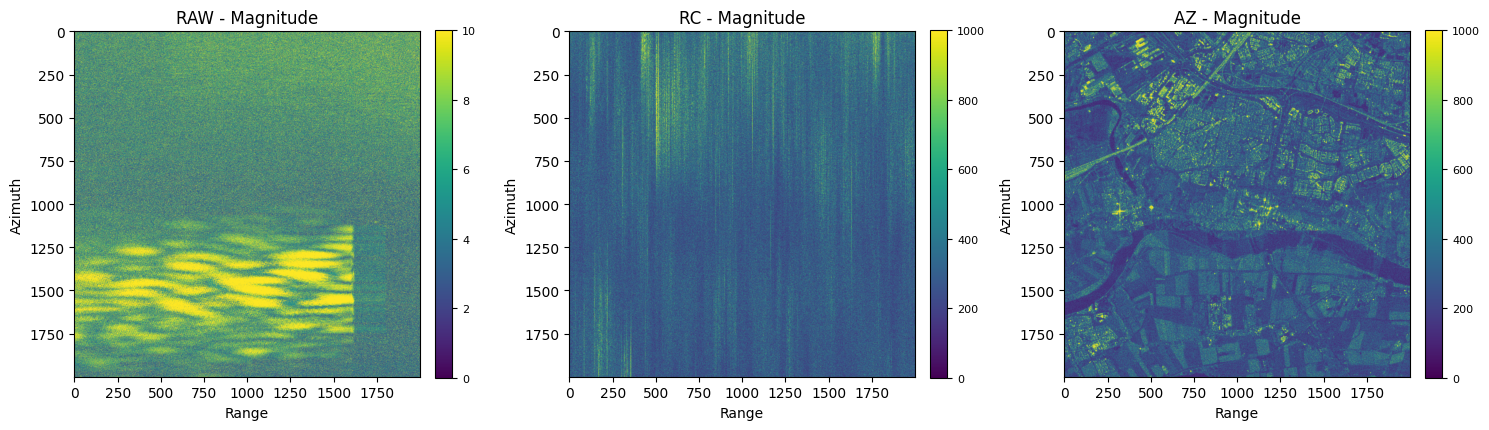

DISPLAYED: s1a-s1-raw-s-vv-20160825t111231-20160825t111302-012756-01415f_burst_1.zarr with rows: 2230-4230 and cols: 21426-23426


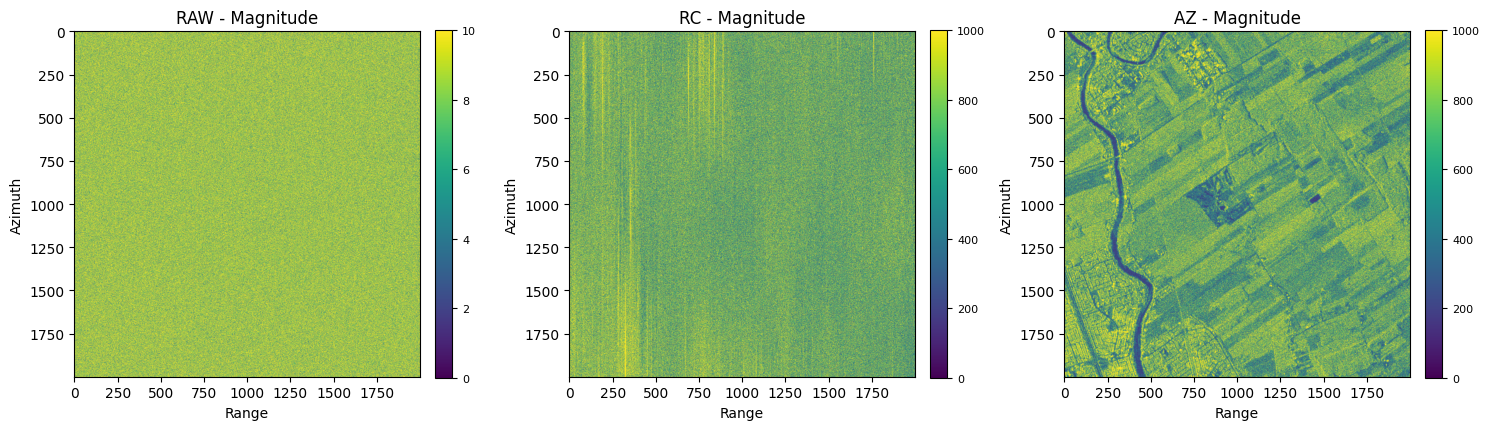

DISPLAYED: s1a-s1-raw-s-vv-20150323t070414-20150323t070447-005155-0067fc_burst_0.zarr with rows: 1707-3707 and cols: 19746-21746


In [ ]:
import matplotlib.pyplot as plt
import numpy as np


for zarr_file in zarr_files:
    filepath = os.path.join('/Data_large/marine/PythonProjects/SAR/sarpyx/data/focused_data_sec_1_2', zarr_file)
    pHandler = ProductHandler(filepath)

    # generate indices generically
    size_w = 2000
    size_h = 2000
    H, W  = d.shape

    row_start, row_end = generate_random_window(size_h, H)
    col_start, col_end = generate_random_window(size_w, W)

    print(f"DISPLAYED: {zarr_file} with rows: {row_start}-{row_end} and cols: {col_start}-{col_end}")

    pHandler.visualize_arrays(
        array_names=['raw','rc','az'], 
        rows=(row_start, row_end), 
        cols=(col_start, col_end),
        plot_type='magnitude',
    )
    

In [ ]:


# generate indices generically
size_w = 2000
size_h = 2000
H, W  = d.shape

for _ in range(5):
    row_start, row_end = generate_random_window(size_h, H)
    col_start, col_end = generate_random_window(size_w, W)

    print(f'Randomly selected window: rows ({row_start}, {row_end}), cols ({col_start}, {col_end})')
    pHandler.visualize_arrays(
        array_names=['raw','rc','az'], 
        rows=(row_start, row_end), 
        cols=(col_start, col_end),
        plot_type='magnitude',
)

Delete tmp

In [ ]:
# remove temporary directory after processing
if tmp.exists():
    for item in tmp.iterdir():
        item.unlink()
    tmp.rmdir()
    print(f'🗑️ Temporary directory {tmp} removed after processing.')

In [ ]:
processor._display_slice(slice=(0,5000,0,35000), vmax=10, step='raw')


In [ ]:
processor._display_slice(slice=(0,5000,0,35000), vmax=1200, step='range_compressed')


In [ ]:
processor._display_slice(slice=(0,5000,0,35000), vmax=1200, step='rcmc')


In [ ]:
processor._display_slice(slice=(0,5000,0,35000), vmax=1200, step='az_compressed')


#### Focus and save in tmp